## Imports
---

In [30]:
import pandas as pd 
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import math
import yfinance as yf
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, atr

## Getting the Data
---

## Polygon API
---

In [32]:
def cog(series, window):
    weights = np.arange(1, window + 1)
    weighted_sum = series.rolling(window).apply(lambda x: np.dot(x, weights[::-1]), raw=True)
    sum_weights = np.sum(weights)
    cog_values = weighted_sum / sum_weights
    return pd.Series(cog_values, index=series.index)

def normalizeDeriv(src, quadraticMeanLength):
    derivative = src - src.shift(2)  # Calculate the derivative
    print(derivative)
    quadraticMean = np.sqrt((derivative ** 2).rolling(quadraticMeanLength).mean())  # Calculate quadratic mean
    print(quadraticMean)
    normalizedDeriv = derivative / quadraticMean  # Calculate normalized derivative
    return normalizedDeriv

def tanh(_src):
    return -1 + 2/(1 + np.exp(-2*_src))

def dualPoleFilter(_src, _lookback):
    _omega = -99 * math.pi / (70 * _lookback)
    _alpha = np.exp(_omega)
    _beta = -np.power(_alpha, 2)
    _gamma = np.cos(_omega) * 2 * _alpha
    _delta = 1 - _gamma - _beta
    _slidingAvg = 0.5 * (_src + np.nan_to_num(_src.shift(1), nan=_src))
    _filter = np.empty_like(_src)
    _filter[0] = np.nan
    
    for i in range(1, len(_src)):
        _filter[i] = (_delta * _slidingAvg[i]) + _gamma * np.nan_to_num(_filter[i-1], nan=0) + _beta * np.nan_to_num(_filter[i-2], nan=0)
    
    return _filter

def getOscillator(data, smoothingFrequency, quadraticMeanLength):
    nDeriv = normalizeDeriv(data, quadraticMeanLength)
    hyperbolicTangent = tanh(nDeriv)
    result = dualPoleFilter(hyperbolicTangent, smoothingFrequency)
    return result

quadraticMeanLength = 50
offsetSlow = 0
s_smoothing = 2.5
s_length = 1.75
quadraticMeanLength = 20    
oscillatorLockback = 20
s_lookback = s_smoothing * oscillatorLockback
signalSlow = getOscillator(cog(forex_data["Close"], 6), s_lookback, quadraticMeanLength)
seriesSlow = s_length*signalSlow+offsetSlow
seriesSlowMirror = -seriesSlow + 2 * offsetSlow


timestamp
2021-06-20 19:00:00         NaN
2021-06-20 19:09:00         NaN
2021-06-20 19:36:00         NaN
2021-06-20 19:42:00         NaN
2021-06-20 19:45:00         NaN
                         ...   
2023-05-19 20:51:00   -0.000039
2023-05-19 20:54:00   -0.000089
2023-05-19 20:57:00   -0.000176
2023-05-19 21:00:00   -0.000151
2023-05-19 21:03:00    0.000023
Name: Close, Length: 238830, dtype: float64
timestamp
2021-06-20 19:00:00         NaN
2021-06-20 19:09:00         NaN
2021-06-20 19:36:00         NaN
2021-06-20 19:42:00         NaN
2021-06-20 19:45:00         NaN
                         ...   
2023-05-19 20:51:00    0.000123
2023-05-19 20:54:00    0.000123
2023-05-19 20:57:00    0.000126
2023-05-19 21:00:00    0.000123
2023-05-19 21:03:00    0.000116
Name: Close, Length: 238830, dtype: float64


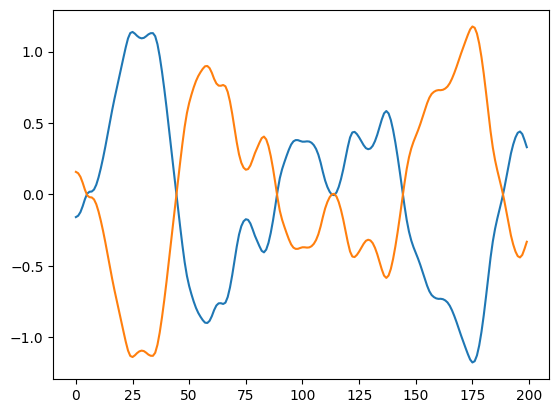

In [33]:
plt.plot(seriesSlow[-200:])
plt.plot(seriesSlowMirror[-200:])

In [157]:
#import modules
from polygon import RESTClient
import datetime as dt

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def getData(ticker, timespan, start, end):
    bars = client.get_aggs(ticker=ticker, multiplier=3, timespan=timespan, from_=start, to=end)
    print(len(bars))


    #list of polygon OptionsContract objects to DataFrame
    downloadedData = pd.DataFrame(bars)

    #create Date column
    downloadedData['Date'] = pd.to_datetime(downloadedData['timestamp'], unit='ms')
    downloadedData['Date'] = pd.to_datetime(downloadedData['Date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
    downloadedData.set_index('Date', inplace=True)

    #drop unnecessary columns
    downloadedData = downloadedData.drop(['vwap', 'transactions', 'otc'], axis=1)
    downloadedData = downloadedData.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})

    return downloadedData


In [ ]:
import os
import pandas as pd
import datetime as dt
import time
from polygon import RESTClient

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def downloadAllData(ticker, timespan, start, end, csv_directory):
    current_start = start
    cumulative_data = pd.DataFrame()

    while current_start < end:
        current_end = min(current_start + pd.DateOffset(days=3), end)
        data = getData(ticker, timespan, current_start, current_end)

        if not data.empty:
            # Create directory if it doesn't exist
            os.makedirs(csv_directory, exist_ok=True)

            # Save data for the current day
            csv_file = os.path.join(csv_directory, f"{current_start.strftime('%Y-%m-%d')}.csv")
            data.to_csv(csv_file)

            # Append data to cumulative dataframe
            cumulative_data = pd.concat([cumulative_data, data])

            print(f"Downloaded data for {current_start} to {current_end}")

        current_start = current_end + pd.DateOffset(days=0)
        time.sleep(61)

    # Save cumulative data to a cumulative CSV file
    cumulative_csv_file = os.path.join(csv_directory, "cumulative_data.csv")
    cumulative_data.to_csv(cumulative_csv_file)

    return cumulative_data

# Example usage
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(days=700)
csv_directory = "data_directory"

data = downloadAllData("C:EURUSD", "minute", start_date, end_date, csv_directory)
print(data.head())
print(data.tail())

## The Strategy
---

In [4]:
forex_data = pd.read_csv("./data_directory/cumulative_data.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)


In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib as tab
class PIES(Strategy):
    
    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        self.taggeddev = 0
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0
        
        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        # VWAP Indicator
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        # Orderblock Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0)
        # ATR Indicator
        self.atr = self.I(tab.ATR, self.data.High, self.data.Low, self.data.Close, 14)

    def next(self):
        # Add orderblocks

        if(self.upperOB[-1] > 0):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if(self.lowerOB[-1] > 0):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        # If no trade is open
        if not self.trade_opened and self.data.index[-1].hour > 6 and self.data.index[-1].hour < 12:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                for high, low, candle in self.orderblocksU:
                    if self.data.High[-1] > low and self.data.High[-1] < high and self.candlecount - candle < 1000 and ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                        self.tagged = True
                        if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                            self.taggeddev = 2
                        else:
                            self.taggeddev = 3
                        self.taggedprice = self.data.High[-1]
                        self.orderblocklow = low
                        self.sholong = 1
                        self.orderblocksU.remove([high, low, candle])
                        break
                for high, low, candle in self.orderblocksB:
                    if self.data.Low[-1] < high and self.data.Low[-1] > low and self.candlecount - candle < 1000 and ((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                        self.tagged = True
                        if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                            self.taggeddev = 2
                        else:
                            self.taggeddev = 3
                        self.orderblockhigh = high
                        self.sholong = 0
                        self.orderblocksB.remove([high, low, candle])
                        break

            # If it hit and we have to go short

            elif (self.tagged == True and self.sholong == 1):
                # Heikin Ashi Candles)
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < 7:
                        if self.data.High[-1] < self.orderblocklow and ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                            self.trade_opened = True
                            self.stoploss = 0
                            for i in range(1, 10):
                                if self.data.High[-i] > self.stoploss:
                                    self.stoploss = self.data.High[-i]
                            def berechnen(kapital, stoploss, entry):
                                    diff = stoploss - entry
                                    size = abs((kapital/10000) / diff)
                                    return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                self.sell(size=sizeO)
                            except:
                                print("Something went wrong")
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                # Heikin Ashi Candles
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                if self.taggedcounter < 7:
                    if self.data.Low[-1] > self.orderblockhigh and ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                        self.stoploss = 100 # Set stoploss to high value
                        for i in range(1, 10):
                            if self.data.Low[-i] < self.stoploss:
                                self.stoploss = self.data.Low[-i]
                        def berechnen(kapital, stoploss, entry):
                            diff = stoploss - entry
                            size = abs((kapital/10000) / diff)
                            return int(round(size,0))
                        sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                        try:
                            self.buy(size=sizeO)
                        except:
                            print("Something went wrong")
                        self.trade_opened = True
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
        

        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1
        
bt2 = Backtest(forex_data[:10000], PIES, cash=10000000, commission=0.00, exclusive_orders=True)
# Run the backtest and append the results to the list
output2 = bt2.run()
# Print the results
print(output2)

bt2.plot(filename="./ChartPlots/PIES_20.05.23_0.html")

NameError: name 'forex_data' is not defined

In [179]:
def berechnen(kapital, stoploss, entry):
    diff = stoploss - entry
    size = abs((kapital/100) / diff)
    return int(round(size,0))

print(berechnen(10000, 1020, 1000))

5
